## Naive Bayes Classifer: Evaluate Analysis

For this challege, we will be building a Navie Bayes classification model to classify whether feedback left on a website is either positive or negative. Our start model will be using data from a Yelp Review dataset.

##Overview of Yelp Review

First, we will explore the data and then select some features to run our inital model.

In [0]:
#Numpy and pandas
import numpy as np
import pandas as pd

#Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#NLP tools
import nltk
from nltk.corpus import stopwords 

#Modeling
import sklearn
from sklearn.naive_bayes import BernoulliNB

#Bag of words model
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

#Cross-validation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [3]:
from google.colab import files
uploaded = files.upload()

Saving yelp_labelled.txt to yelp_labelled.txt


In [4]:
import io
yelp_raw = pd.read_csv(io.BytesIO(uploaded['yelp_labelled.txt']), error_bad_lines=False ,  delimiter='\t', header=None)
yelp_raw.columns = ['review','sentiment']
yelp_raw.head()

,review,sentiment
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


In [5]:

# Check info 

yelp_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
review       1000 non-null object
sentiment    1000 non-null int64
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [6]:

# Check how many datapoints per column 

yelp_raw['sentiment'].value_counts()

1    500
0    500
Name: sentiment, dtype: int64

This dataset contains 1,000 rows and two columns, review text and sentiment scores (1 = positive, 0 = negative). The sentiments scores are split even with 500 obersevations in each class

###Iteration 1


Next, we will construct a set of keywords for negative sentiment.

In [7]:
# Taking a look at negative reviews

neg_reviews = yelp_raw.loc[yelp_raw['sentiment']== 0]
neg_reviews.head()

,review,sentiment
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
5,Now I am getting angry and I want my damn pho.,0
6,Honeslty it didn't taste THAT fresh.),0
7,The potatoes were like rubber and you could te...,0


In [0]:
# Create negative keywords 

neg_keywords = ['angry', 'slow', 'never', 'poor',
                'bad', 'horrible', 'old', 'bland', 'overpriced',
               'rude', 'terrible','wait','waste',
                'never']

for key in neg_keywords:
    # Note that we add spaces around the key so that we're getting the word,
    # not just pattern matching.
    yelp_raw[str(key)] = yelp_raw.review.str.contains(
        ' ' + str(key) + ' ',
        case=False
    )

Before we continue, one main assumption of Naive Bayes is that the variables fed into the model are independent of each other. Let's check to see how true that is by using a correlation maxtrix and a heatmap from seaborn.

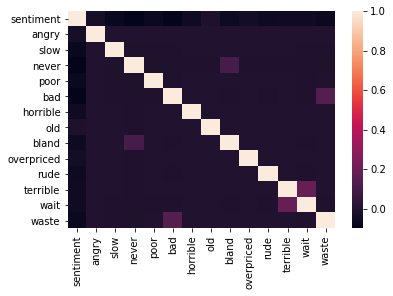

In [10]:

# Create heatmap 

sns.heatmap(yelp_raw.corr())

Since most of the words are not strongly correlated to each other. We will continue by building out our training data with SKLearn. In this step, we will specify an outcome and input variable.

In [0]:

data = yelp_raw[neg_keywords]
target = yelp_raw['sentiment']

In [13]:

# Our data is binary / boolean, so we're importing the Bernoulli classifier.
from sklearn.naive_bayes import BernoulliNB

# Instantiate our model and store it in a new variable.
bnb = BernoulliNB()

# Fit our model to the data.
bnb.fit(data, target)

# Classify, storing the result in a new variable.
y_pred = bnb.predict(data)

# Display our results.
print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred).sum()
))

Number of mislabeled points out of a total 1000 points : 441


With our initial model, we missed classified 44.1% of the data points.

To improve our model, let's calculate what kind of errors we're generating. First, we will use a confusion matrix to shows the count of each possible permutation of target and prediction. Then, use the information to calculate type 1 and type 2 errors. Type 1 errors are false positives where identify the review as negative, while it's not. On the other hand, type 2 errors are false negatives where we will failed to identify a negative review.

In [14]:

# Generate confusion matrix

confusion1 = confusion_matrix(target, y_pred)

pd.DataFrame(
    confusion1, 
    columns=["Negatives", "Positives"],
    index=["Negatives", "Positives"])

,Negatives,Positives
Negatives,65,435
Positives,6,494


In [15]:

# Calculate type 1 and type 2 error

type1_error = confusion1[1][0]/(confusion1[1][0]+confusion1[1][1])*100
print('Type 1 error: '+str(type1_error)+'%')

type2_error = confusion1[0][1]/(confusion1[0][0]+confusion1[0][1])*100
print('Type 2 error: '+str(type2_error)+'%')

Type 1 error: 1.2%
Type 2 error: 87.0%


Our current model is sensitive in classifying positive reviews since we only missclassifed 1.2% of the reviews as positive. However, there is a high precentage of type 2 error which indicates our specifity method in identifying negative reviews is not efficent. We failed to identify 87% of the negative reviews as negative.

###Iteration 2 with tokenization

To improve our model, we will clean and tokenize the review by stripping spaces, casting lowercase, removing non-alphabetic characters and separating into words. Then, we will use Bag of Words to generate a matrix of the occurance of words in the Yelp reviews.

In [0]:

# Basic function to clean the text
def clean_text(text):
    # Removing spaces and converting text into lowercase
    return text.strip().lower().replace('[^a-zA-Z]', ' ')

In [0]:

# Create new data frame for cleaning

yelp_clean = yelp_raw.loc[:,['review','sentiment']]
yelp_clean['review'] = yelp_clean['review'].astype('str')

yelp_clean['token'] = yelp_clean['review'].apply(lambda x: clean_text(x))

Next, we will use Count Vectorizer to tokenize the review column by generating an array for each row and a column of a word. A boolean will indicate whether the word is present in the row or not.

In [18]:

#Use CountVectorizer to generate an array of unigram counts for each review

vectorizer = CountVectorizer(stop_words=None, max_features=None)
X = vectorizer.fit(yelp_clean['token'])
X = vectorizer.transform(yelp_clean['token'])

#Use term frequency - inverse document frequency transformation to weight more informative unigrams

tfidf_transformer = TfidfTransformer().fit(X)
X_tfidf = tfidf_transformer.transform(X)

#Take a look at the shape of the array

print(X_tfidf.shape)

(1000, 2035)


There are 1,000 reviews and 2,034 unigrams in this array.

Now, we will create a second model by using bag of words instead of manually selecting list of negative keywords from the first model.

In [19]:

#Refit the model using tfidf in place of the manually constructed keywords list

bnb.fit(X_tfidf, target)
y_pred2 = bnb.predict(X_tfidf)

#Read out the result

print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target != y_pred2).sum()
))

Number of mislabeled points out of a total 1000 points : 55


This model correctly classified 94.5% of datapoints! This appears to be more accurate than our first model.

Let's use a confusion matrix to analyze our errors.

In [20]:
#Evaluate confusion matrix 

confusion2 = confusion_matrix(target, y_pred2)
print(confusion2)

type1_error = confusion2[1][0]/(confusion2[1][0]+confusion2[1][1])*100
print('Type 1 error: '+str(round(type1_error))+'%')

type2_error = confusion2[0][1]/(confusion2[0][0]+confusion2[0][1])*100
print('Type 2 error: '+str(type2_error)+'%')

[[474  26]
 [ 29 471]]
Type 1 error: 6.0%
Type 2 error: 5.2%


Here, we can see that type 1 error has increased to 6%. We misclassfied 29 out of 474 positive reviews. The type 2 error has drastically decreased from last time. It appears that this model outperformed the first model in properly identifying negative reviews since we only failed to identified 26 negative reviews.

###Overfitting

We built the bag of words based on the entire dataset which overfits the model. An overfitted model can start to catch random noise instead of describing the true underlying relationships. Let's try applying this process again with another dataset.

###Iteration 3 splitting Amazon dataset and tokenization


In this model, we will using the Amazon dataset to fit the model. We will clean the data, tokenize the dataset, and split the data into a training and testing set.

In [22]:
from google.colab import files
uploaded = files.upload()

Saving amazon_cells_labelled.txt to amazon_cells_labelled.txt


In [25]:
import io
amazon_raw = pd.read_csv(io.BytesIO(uploaded['amazon_cells_labelled.txt']), error_bad_lines=False ,  delimiter='\t', header=None)
amazon_raw.columns = ['review','sentiment']
amazon_raw.head()

,review,sentiment
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1



The Amazon dataset appears to have the same content and shape as the Yelp dataset.

In [0]:

# Clean data

amazon_clean = amazon_raw.loc[:,['review','sentiment']]
amazon_clean['review'] = amazon_clean['review'].astype('str')

amazon_clean['token'] = amazon_clean['review'].apply(lambda x: clean_text(x))

In [0]:

target_am = amazon_clean['sentiment']

In [0]:
# Split data into training and testing set

X = amazon_clean['token'] # the features we want to analyze
ylabels = amazon_clean['sentiment'] # the labels, or answers, we want to test against

X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.3)

In [29]:

#Use CountVectorizer to generate an array of unigram counts for each review

vectorizer = CountVectorizer(stop_words=None, max_features=None)
X = vectorizer.fit(amazon_clean['token'])
X = vectorizer.transform(amazon_clean['token'])

#Use term frequency - inverse document frequency transformation to weight more informative unigrams

tfidf_transformer = TfidfTransformer().fit(X)
X_tfidf = tfidf_transformer.transform(X)

#Take a look at the shape of the array

print(X_tfidf.shape)

(1000, 1847)


In this dataset, we are separating the data into a training and testing set. The testing set will be 30% of the data.

There are 1,000 reviews and 1,847 unigrams in this array.

In [30]:

#Refit the model using tfidf in place of the manually constructed keywords list

bnb.fit(X_tfidf, target_am)
y_pred3 = bnb.predict(X_tfidf)

#Read out the result

print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target_am != y_pred3).sum()
))

Number of mislabeled points out of a total 1000 points : 41


In [31]:
#Evaluate the result in a confusion matrix

confusion_am = confusion_matrix(target_am, y_pred3)
print(confusion_am)

type1_error = confusion_am[1][0]/(confusion_am[1][0]+confusion_am[1][1])*100
print('Type 1 error: '+str(round(type1_error))+'%')

type2_error = confusion_am[0][1]/(confusion_am[0][0]+confusion_am[0][1])*100
print('Type 2 error: '+str(round(type2_error))+'%')

[[468  32]
 [  9 491]]
Type 1 error: 2.0%
Type 2 error: 6.0%


With our third model, we were able to correctly classify 14 more reviews than the second model. This model has a 95.9% accuracy rate. We misclassfied 9 positive reviews and 32 negative reviews.

To improve our classification model, we will reevaluate it and cross-validate our data to prevent overfitting.

We will revisit the Yelp dataset to see if we have made progress in classifying the reviews.

###Cross Validation

Let's trying running the Yelp bag of words after spliting the Yelp dataset. Here, we will be testing only 30% of the Yelp Review data.

In [0]:

target_ye = yelp_clean['sentiment']

In [0]:

# Split data into training and testing set

X = yelp_clean['token'] # the features we want to analyze
ylabels = yelp_clean['sentiment'] # the labels, or answers, we want to test against

X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.3)

In [34]:
#Use CountVectorizer to generate an array of unigram counts for each review

vectorizer = CountVectorizer(stop_words=None, max_features=None)
X = vectorizer.fit(yelp_clean['token'])
X = vectorizer.transform(yelp_clean['token'])

#Use term frequency - inverse document frequency transformation to weight more informative unigrams

tfidf_transformer = TfidfTransformer().fit(X)
X_tfidf = tfidf_transformer.transform(X)

#Take a look at the shape of the array

print(X_tfidf.shape)

(1000, 2035)


There are 1,000 reviews and 2,035 unigrams in this array.

Now, we will continue by refitting the model with the new bag of words after splitting the data.

In [35]:

#Refit the model using tfidf in place of the manually constructed keywords list

bnb.fit(X_tfidf, target_ye)
y_pred4 = bnb.predict(X_tfidf)

#Read out the result

print("Number of mislabeled points out of a total {} points : {}".format(
    data.shape[0],
    (target_ye != y_pred4).sum()
))

Number of mislabeled points out of a total 1000 points : 55


In [36]:

#Evaluate the result in a confusion matrix

confusion_ye = confusion_matrix(target_ye, y_pred4)
print(confusion_ye)

type1_error = confusion_ye[1][0]/(confusion_ye[1][0]+confusion_ye[1][1])*100
print('Type 1 error: '+str(round(type1_error))+'%')

type2_error = confusion_ye[0][1]/(confusion_ye[0][0]+confusion_ye[0][1])*100
print('Type 2 error: '+str(round(type2_error))+'%')

[[474  26]
 [ 29 471]]
Type 1 error: 6.0%
Type 2 error: 5.0%


The result of this model resembles our second model where we first introduced bag of words without splitting the data. This model yields 94.5% accuracy as the second model, but has a slightly different ratio of type errors. We misclassified 29 positive reviews and 26 negative reviews.

Next, we will continue to analyze the accuracy of our model by using cross validation to lower the amount of noise dection. Instead of splitting the data into 30 test and 70 train, we will use 10 random folds. We will also introduce limit parameter to the count vectorize to minimize overfitting the data.

In [0]:

# create X (features) and y (response)

X = yelp_clean['token']
y = yelp_clean['sentiment']
yelp_token = yelp_clean['token']

In [38]:
kf = KFold(n_splits=10, shuffle=True)
pipeline = Pipeline([
    ('vectorizer',  CountVectorizer(stop_words='english', min_df=2, max_df=0.8)),
    ('tfidf', TfidfTransformer()),
    ('classifier',  BernoulliNB()),
    ])
num = 1
for train_index, test_index in kf.split(yelp_token):
    X_train, X_test = yelp_token[train_index], yelp_token[test_index]
    y_train, y_test = target[train_index], target[test_index]
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)
    
    
    #Evaluate the results
    print('------------------')
    print('Fold '+str(num))
    print("Number of mislabeled points out of a total {} points : {}".format(
    (round(data.shape[0]/10)),
    (target[test_index] != predictions).sum()
))
    confusion = confusion_matrix(y_test, predictions)
    print(confusion)
    
    type1_error = confusion[1][0]/(confusion[1][0]+confusion[1][1])*100
    print('Type 1 error: '+str(round(type1_error))+'%')
    
    type2_error = confusion[0][1]/(confusion[0][0]+confusion[0][1])*100
    print('Type 2 error: '+str(round(type2_error))+'%')
    
    num+=1

------------------
Fold 1
Number of mislabeled points out of a total 100 points : 31
[[33 13]
 [18 36]]
Type 1 error: 33.0%
Type 2 error: 28.0%
------------------
Fold 2
Number of mislabeled points out of a total 100 points : 21
[[38 13]
 [ 8 41]]
Type 1 error: 16.0%
Type 2 error: 25.0%
------------------
Fold 3
Number of mislabeled points out of a total 100 points : 29
[[36 14]
 [15 35]]
Type 1 error: 30.0%
Type 2 error: 28.0%
------------------
Fold 4
Number of mislabeled points out of a total 100 points : 16
[[40  9]
 [ 7 44]]
Type 1 error: 14.0%
Type 2 error: 18.0%
------------------
Fold 5
Number of mislabeled points out of a total 100 points : 24
[[34 11]
 [13 42]]
Type 1 error: 24.0%
Type 2 error: 24.0%
------------------
Fold 6
Number of mislabeled points out of a total 100 points : 24
[[36 14]
 [10 40]]
Type 1 error: 20.0%
Type 2 error: 28.0%
------------------
Fold 7
Number of mislabeled points out of a total 100 points : 19
[[33 12]
 [ 7 48]]
Type 1 error: 13.0%
Type 2 error

In [39]:
cross_val_score(bnb, data, target, cv=10)

array([0.6 , 0.55, 0.57, 0.54, 0.55, 0.54, 0.55, 0.58, 0.55, 0.53])

fter running the third model through 10 random folds, the accuracy of the model ranges from 70% to 80%. This shows that there is stability within the model process. If given a new set of data, the model should be able to produce 70% to 80% accuracy. Although this accuracy rate may not be excellent, is is definitely better than our first model without counter vectorization.
Other parameters might be able to improve the performance of our current model. Also, feature selections that are more complex than a Naives Baynes classification might improve the accuracy of the model.